In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp /content/gdrive/My\ Drive/faces.zip ./faces.zip
!unzip faces.zip
!mkdir manga_faces
!mv faces manga_faces/faces

In [0]:
!cp /content/gdrive/My\ Drive/celeba.zip ./celeba.zip
!unzip celeba.zip
!mkdir photo_faces
!mv celeba-128 photo_faces/celeba-128

In [0]:
!git clone https://github.com/Yuan-T-Xuan/dl-project.git
!cp -r dl-project/* ./

Cloning into 'dl-project'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 38 (delta 19), reused 25 (delta 9), pack-reused 0
Unpacking objects: 100% (38/38), done.


In [0]:
!ls

celeba.zip	faces.zip    model.py	  sample_data
data_loader.py	gdrive	     photo_faces  test_trained_model.py
dl-project	manga_faces  README.md	  train.py


In [0]:
import torch
import model
from model import init_weights
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import optim

def loss_D(real_imgs, generated_imgs, dis):
    part1 = torch.mean((dis(real_imgs) - 1.0).pow(2))
    part2 = torch.mean(dis(generated_imgs).pow(2))
    return (part1 + part2) / 10.0

def loss_G(generated_imgs, dis):
    return torch.mean((dis(generated_imgs) - 1.0).pow(2))

def loss_cyc(generated_x, generated_y, imgs_x, imgs_y, G, F):
    part1 = torch.mean((F(generated_y) - imgs_x).pow(2))
    part2 = torch.mean((G(generated_x) - imgs_y).pow(2))
    return part1 + part2

def train(G, F, Dx, Dy, lr, data_loader_x, data_loader_y, epochs, lmbda, e_offset=0):
    optimizer_G = optim.Adam(G.parameters(), lr = lr)
    optimizer_F = optim.Adam(F.parameters(), lr = lr)
    optimizer_Dx = optim.Adam(Dx.parameters(), lr = lr)
    optimizer_Dy = optim.Adam(Dy.parameters(), lr = lr)
    for e in range(epochs):
        print(e)
        if e > 0 and e % 2 == 0:
            torch.save(G, "/content/gdrive/My Drive/model2_test4/saved_G_" + str(e_offset+e) + ".pt")
            torch.save(F, "/content/gdrive/My Drive/model2_test4/saved_F_" + str(e_offset+e) + ".pt")
            torch.save(Dx, "/content/gdrive/My Drive/model2_test4/saved_Dx_" + str(e_offset+e) + ".pt")
            torch.save(Dy, "/content/gdrive/My Drive/model2_test4/saved_Dy_" + str(e_offset+e) + ".pt")
            #
        _iter_y = data_loader_y.__iter__()
        for_plot_GF = list()
        for_plot_Dx = list()
        for_plot_Dy = list()
        _iter_x2 = data_loader_x.__iter__()
        _iter_y2 = data_loader_y.__iter__()
        for _imgs_x, _ in tqdm(data_loader_x):
            _imgs_y = _iter_y.__next__()[0]
            _imgs_x = _imgs_x.cuda()
            _imgs_y = _imgs_y.cuda()
            generated_x = F(_imgs_y)
            generated_y = G(_imgs_x)
            # train Ds
            Dx.zero_grad()
            loss_x = loss_D(_imgs_x, generated_x, Dx)
            for_plot_Dx.append(loss_x.item())
            loss_x.backward()
            optimizer_Dx.step()
            Dy.zero_grad()
            loss_y = loss_D(_imgs_y, generated_y, Dy)
            for_plot_Dy.append(loss_y.item())
            loss_y.backward()
            optimizer_Dy.step()
            # train G and F
            _imgs_x = _iter_x2.__next__()[0]
            _imgs_y = _iter_y2.__next__()[0]
            _imgs_x = _imgs_x.cuda()
            _imgs_y = _imgs_y.cuda()
            generated_x = F(_imgs_y)
            generated_y = G(_imgs_x)
            G.zero_grad()
            F.zero_grad()
            loss = loss_G(generated_x, Dx) + loss_G(generated_y, Dy) + lmbda * loss_cyc(generated_x, generated_y, _imgs_x, _imgs_y, G, F)
            for_plot_GF.append(loss.item())
            loss.backward()
            optimizer_G.step()
            optimizer_F.step()
        plt.plot(for_plot_Dx)
        plt.show()
        plt.plot(for_plot_Dy)
        plt.show()
        plt.plot(for_plot_GF)
        plt.show()


In [0]:
from data_loader import *

dl_manga = get_dataloader(path="./manga_faces", batch_size=100)
dl_photo = get_dataloader(path="./photo_faces", batch_size=100)
g = model.G().cuda()
f = model.G().cuda()
dx = model.D().cuda()
dy = model.D().cuda()

g.apply(init_weights)
f.apply(init_weights)
dx.apply(init_weights)
dy.apply(init_weights)

/content/model.py:7: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(m.weight, mean=0, std=0.02)


D(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (norm2): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (norm3): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv4): Conv2d(256, 512, kernel_size=(24, 24), stride=(1, 1))
  (norm4): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (out): Linear(in_features=512, out_features=1, bias=True)
)

0


100%|██████████| 300/300 [31:35<00:00,  6.36s/it]


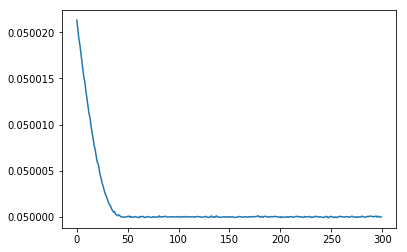

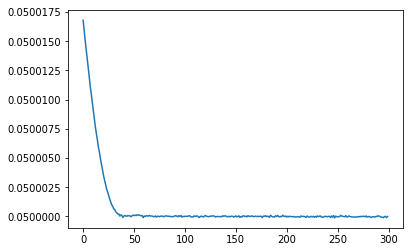

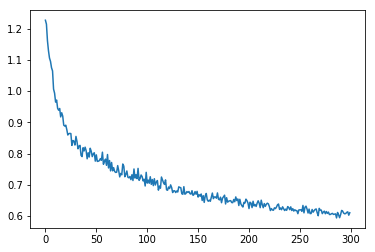

1


100%|██████████| 300/300 [31:43<00:00,  6.36s/it]


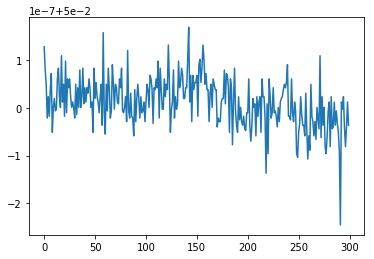

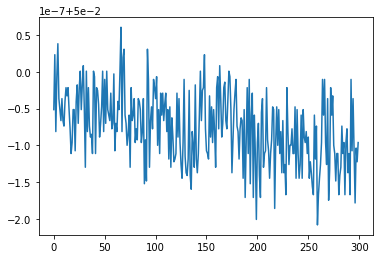

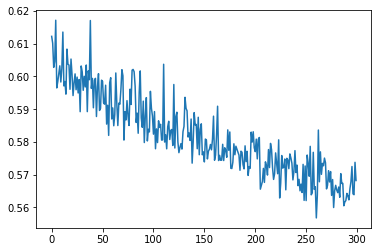

2


100%|██████████| 300/300 [31:41<00:00,  6.34s/it]


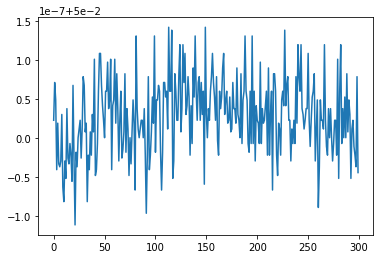

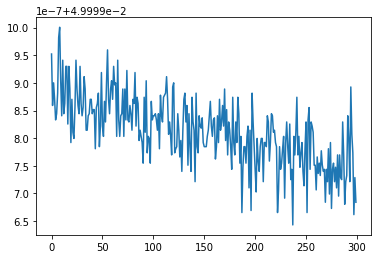

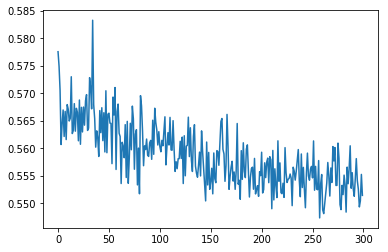

3


100%|██████████| 300/300 [31:43<00:00,  6.36s/it]


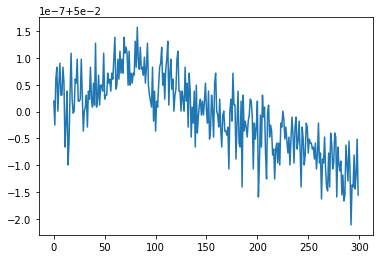

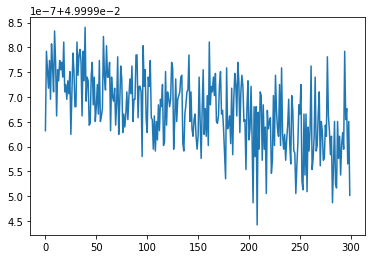

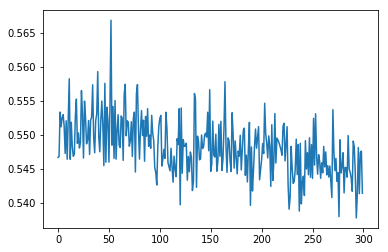

4


100%|██████████| 300/300 [31:46<00:00,  6.38s/it]


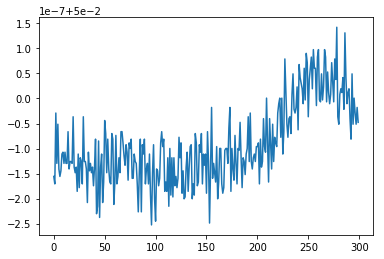

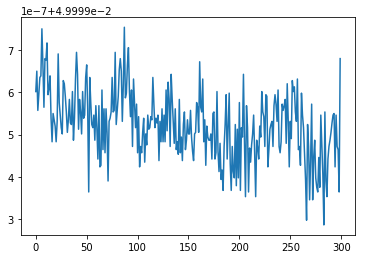

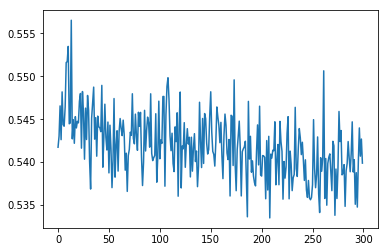

5


100%|██████████| 300/300 [31:45<00:00,  6.35s/it]


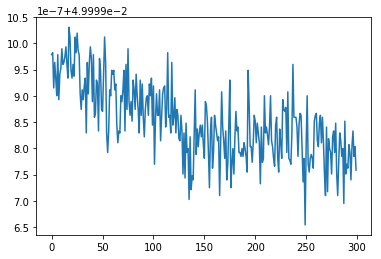

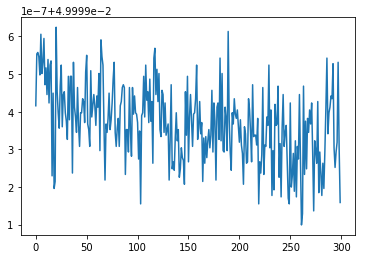

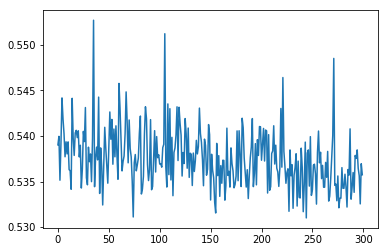

6


100%|██████████| 300/300 [31:46<00:00,  6.32s/it]


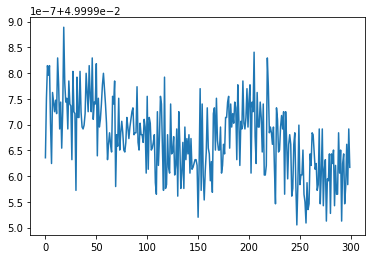

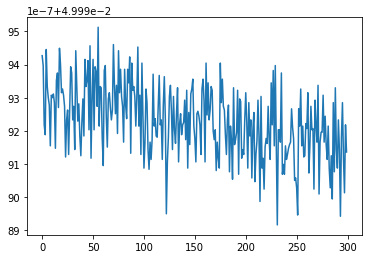

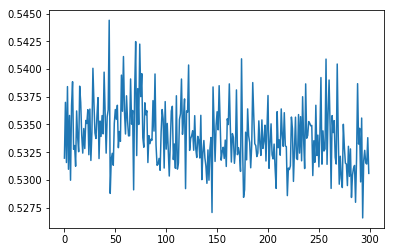

7


100%|██████████| 300/300 [31:45<00:00,  6.36s/it]


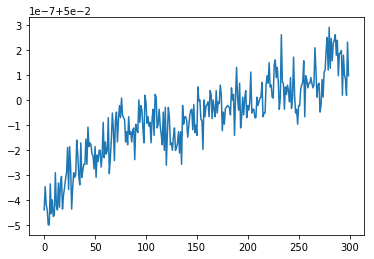

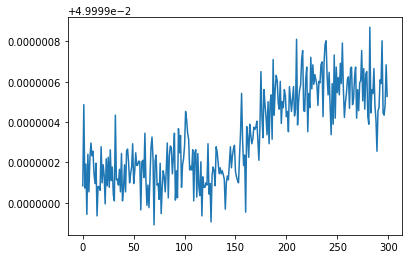

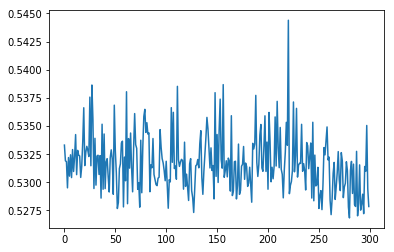

8


100%|██████████| 300/300 [31:48<00:00,  6.34s/it]


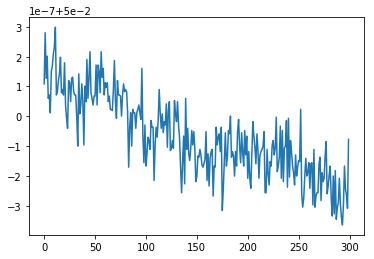

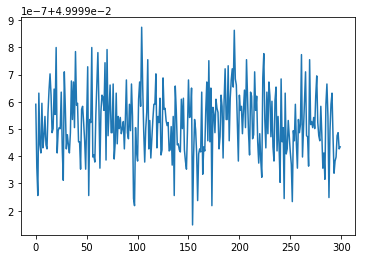

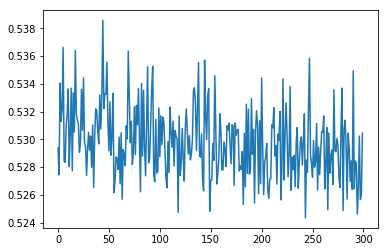

9


100%|██████████| 300/300 [31:46<00:00,  6.37s/it]


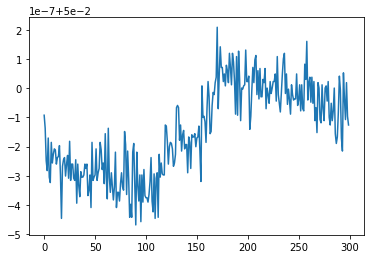

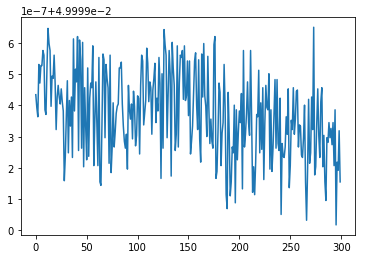

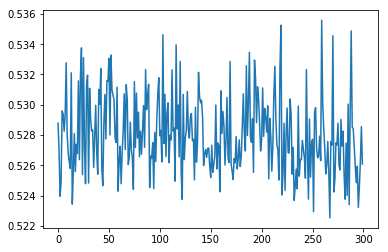

10


100%|██████████| 300/300 [31:46<00:00,  6.36s/it]


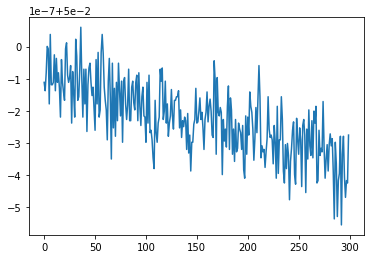

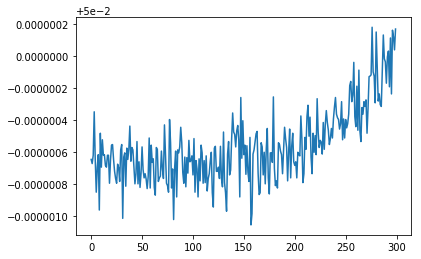

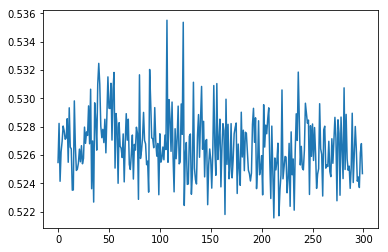

11


100%|██████████| 300/300 [31:46<00:00,  6.36s/it]


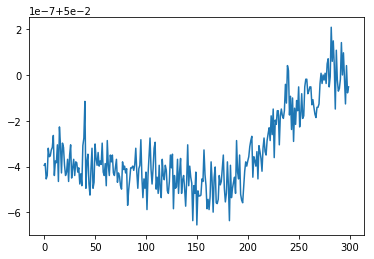

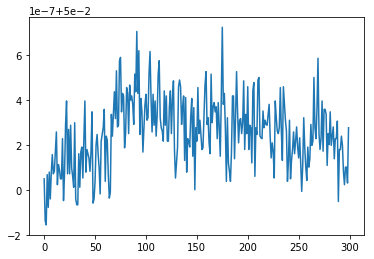

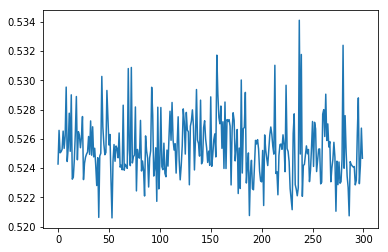

12


  1%|          | 3/300 [00:20<33:47,  6.83s/it]

In [0]:
train(g, f, dx, dy, 0.0001, dl_photo, dl_manga, epochs=50, lmbda=1)

In [0]:
from data_loader import *

dl_manga = get_dataloader(path="./manga_faces", batch_size=100)
dl_photo = get_dataloader(path="./photo_faces", batch_size=100)
g = torch.load("/content/gdrive/My Drive/model2_test4/saved_G_14.pt", map_location='cuda')
f = torch.load("/content/gdrive/My Drive/model2_test4/saved_F_14.pt", map_location='cuda')
dx = torch.load("/content/gdrive/My Drive/model2_test4/saved_Dx_14.pt", map_location='cuda')
dy = torch.load("/content/gdrive/My Drive/model2_test4/saved_Dy_14.pt", map_location='cuda')

0


100%|██████████| 300/300 [29:16<00:00,  5.87s/it]


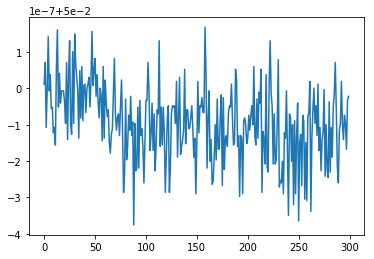

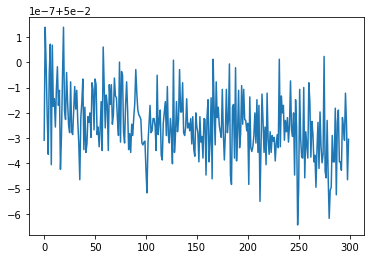

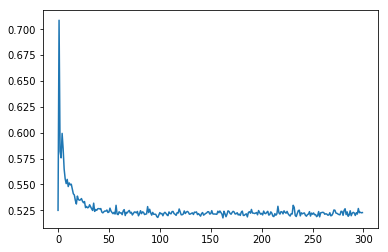

1


100%|██████████| 300/300 [29:20<00:00,  5.86s/it]


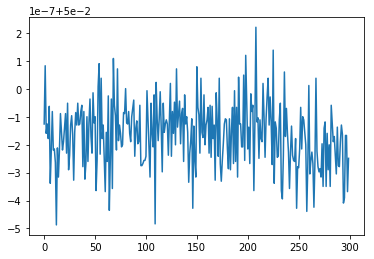

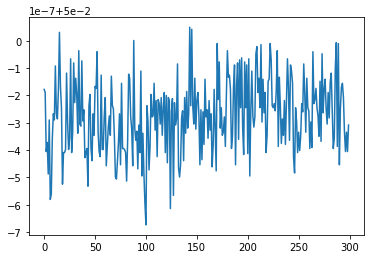

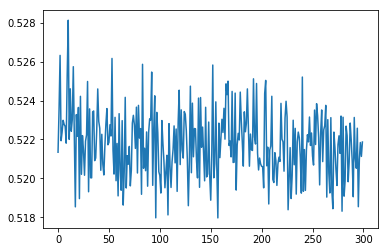

2


100%|██████████| 300/300 [29:22<00:00,  5.87s/it]


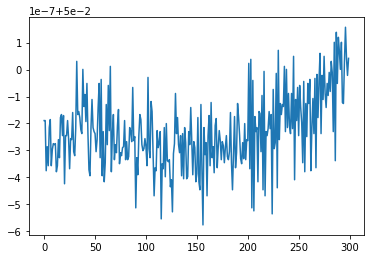

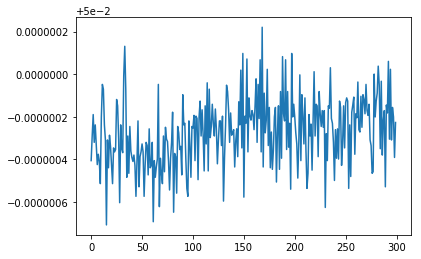

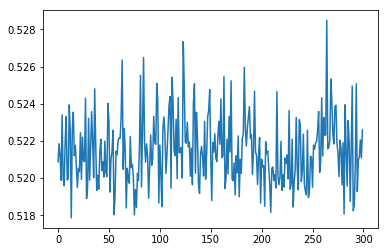

3


100%|██████████| 300/300 [29:21<00:00,  5.86s/it]


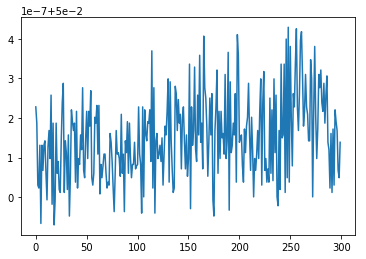

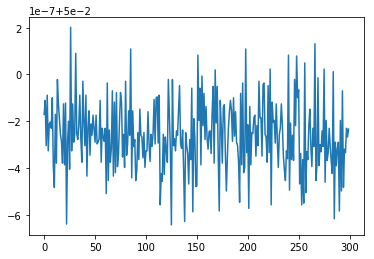

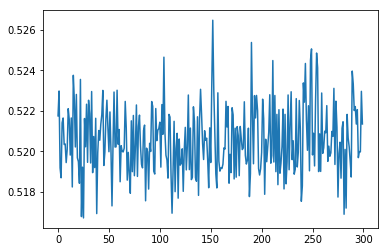

4


100%|██████████| 300/300 [29:22<00:00,  5.86s/it]


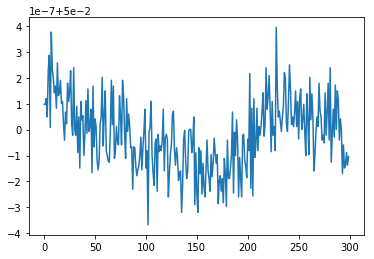

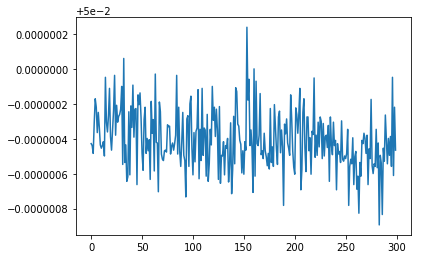

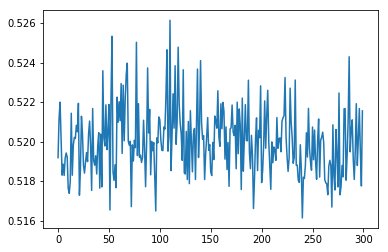

5


100%|██████████| 300/300 [29:23<00:00,  5.86s/it]


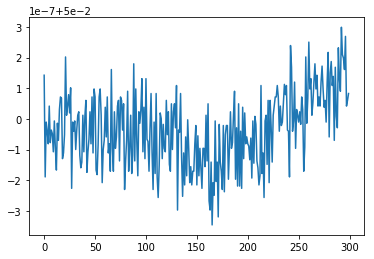

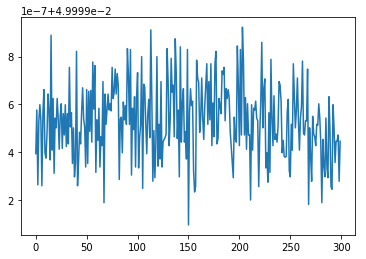

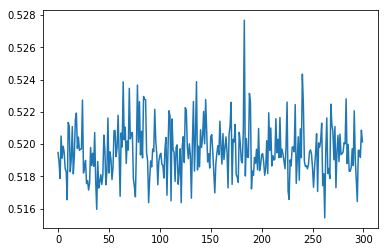

6


100%|██████████| 300/300 [29:22<00:00,  5.85s/it]


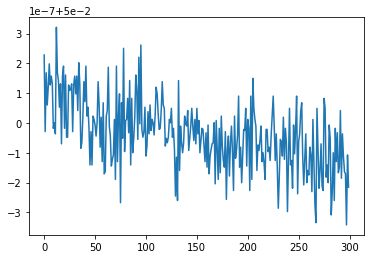

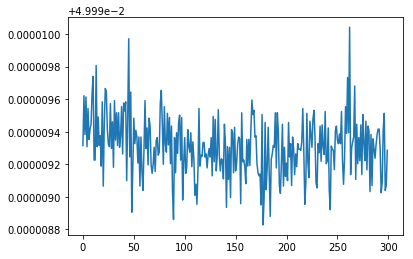

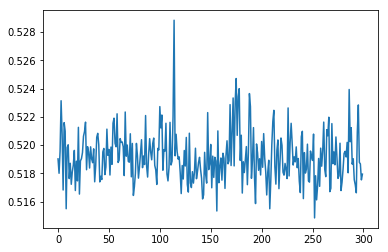

7


100%|██████████| 300/300 [29:20<00:00,  5.86s/it]


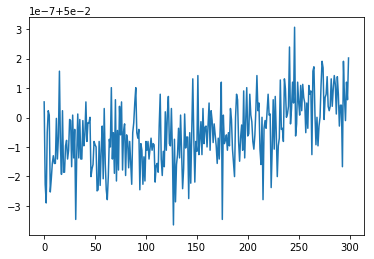

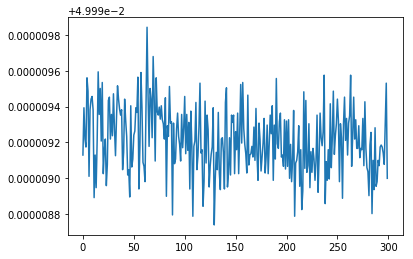

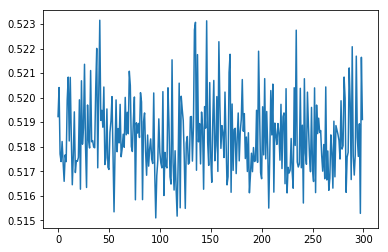

8


100%|██████████| 300/300 [29:21<00:00,  5.87s/it]


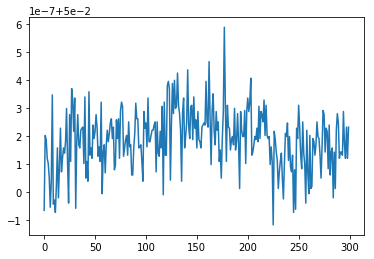

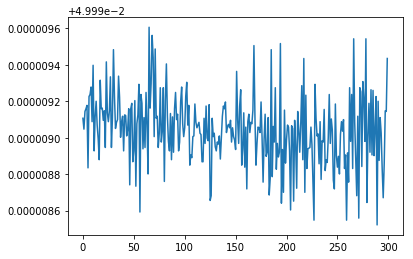

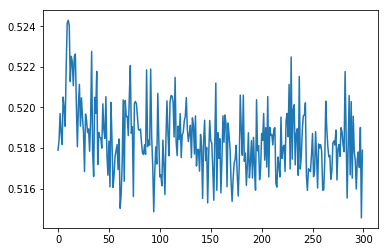

9


100%|██████████| 300/300 [29:23<00:00,  5.86s/it]


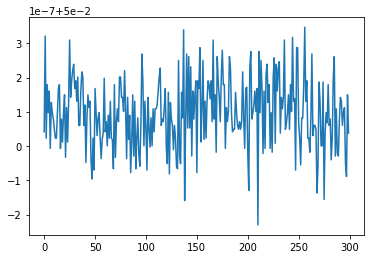

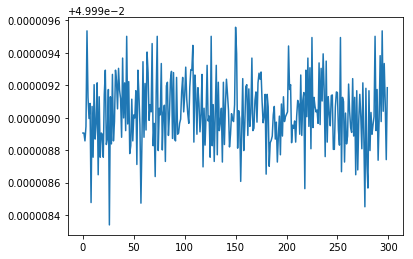

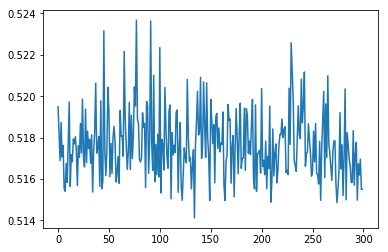

10


100%|██████████| 300/300 [29:22<00:00,  5.86s/it]


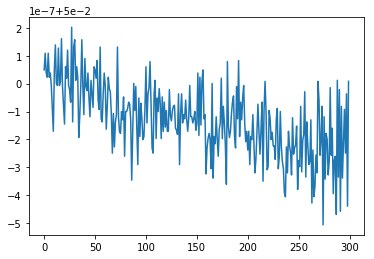

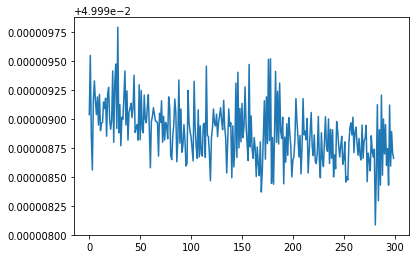

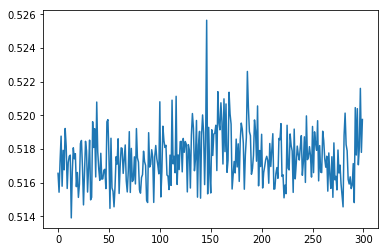

11


100%|██████████| 300/300 [29:21<00:00,  5.85s/it]


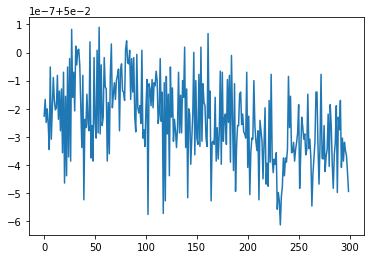

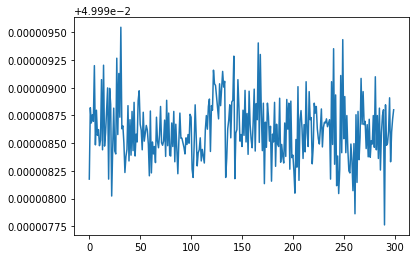

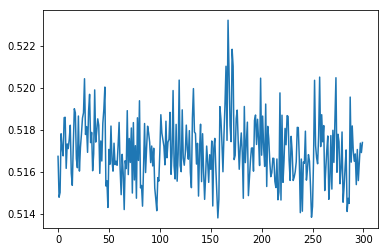

12


100%|██████████| 300/300 [29:21<00:00,  5.86s/it]


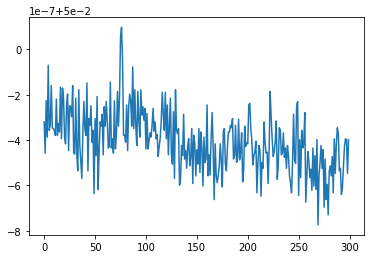

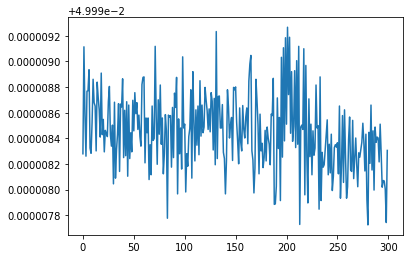

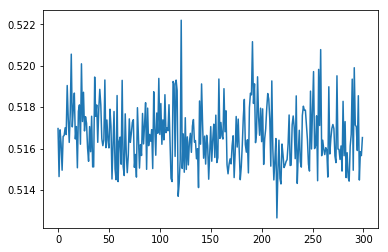

13


100%|██████████| 300/300 [29:13<00:00,  5.80s/it]


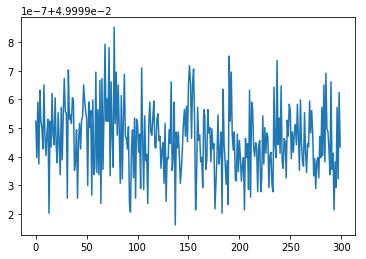

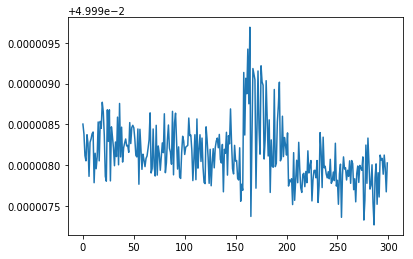

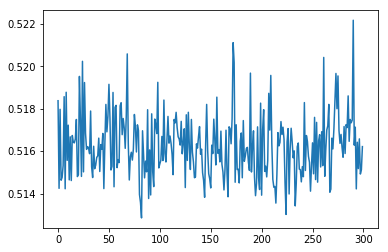

14


100%|██████████| 300/300 [29:17<00:00,  5.83s/it]


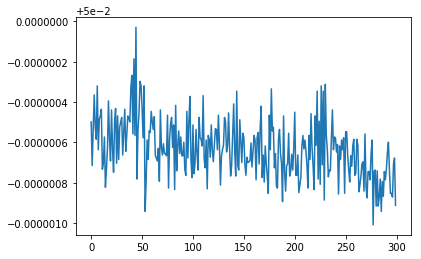

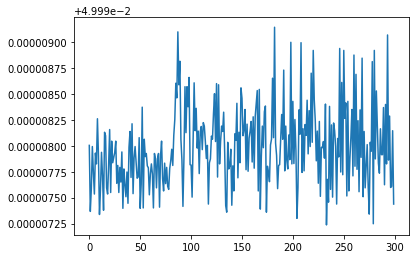

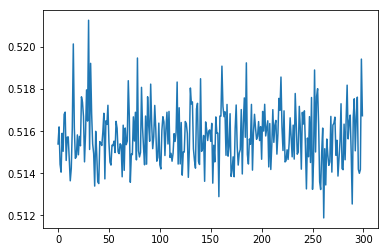

15


100%|██████████| 300/300 [29:20<00:00,  5.86s/it]


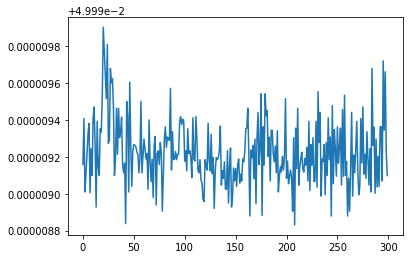

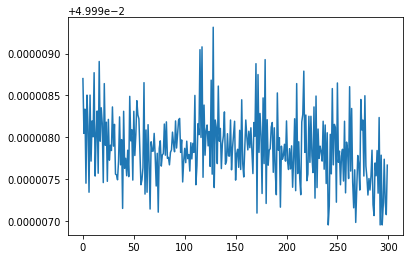

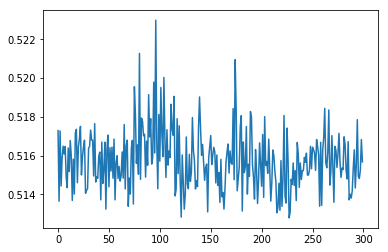

16


100%|██████████| 300/300 [29:18<00:00,  5.85s/it]


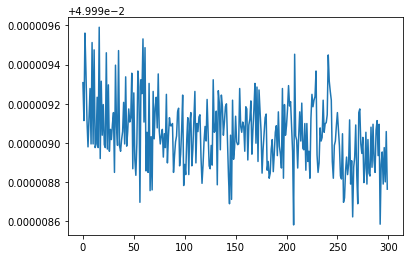

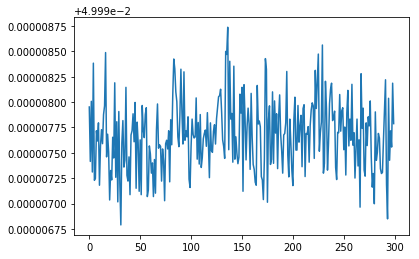

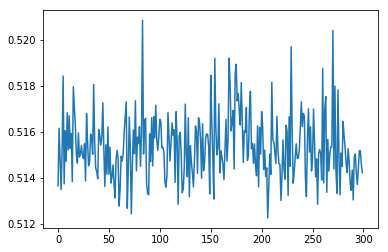

17


100%|██████████| 300/300 [29:18<00:00,  5.84s/it]


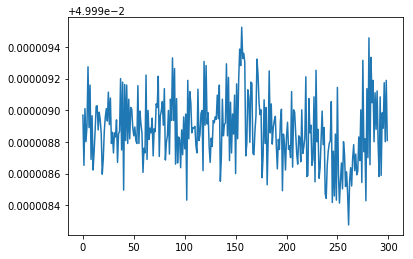

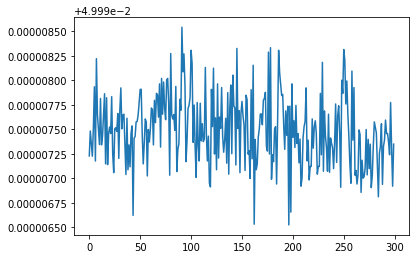

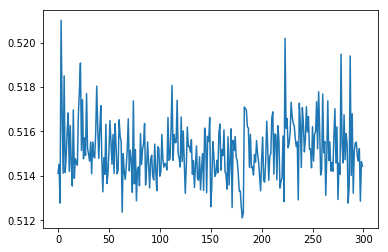

18


100%|██████████| 300/300 [29:18<00:00,  5.86s/it]


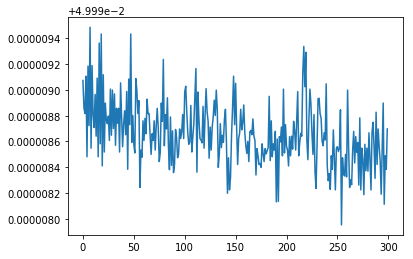

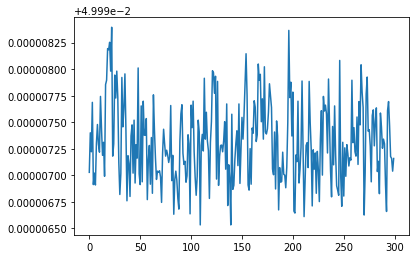

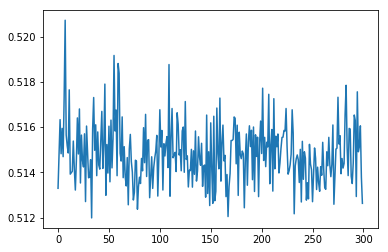

19


100%|██████████| 300/300 [29:18<00:00,  5.86s/it]


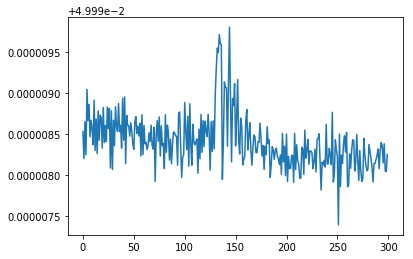

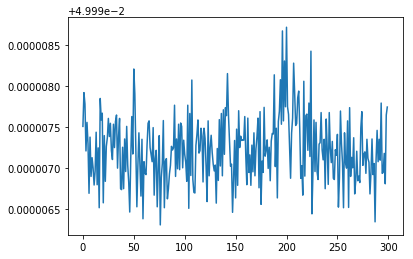

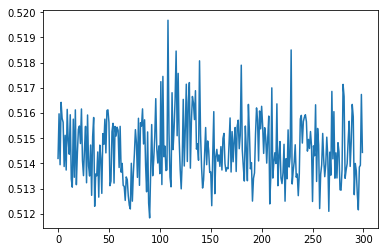

20


100%|██████████| 300/300 [29:18<00:00,  5.84s/it]


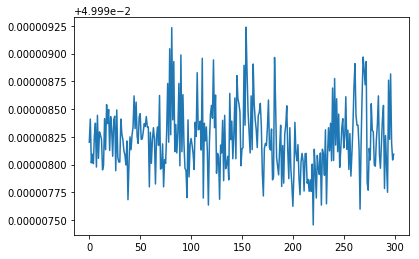

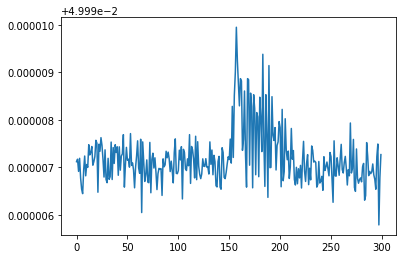

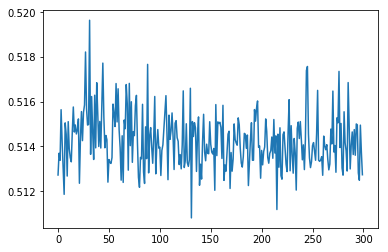

21


100%|██████████| 300/300 [29:19<00:00,  5.85s/it]


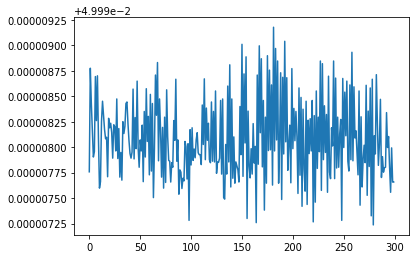

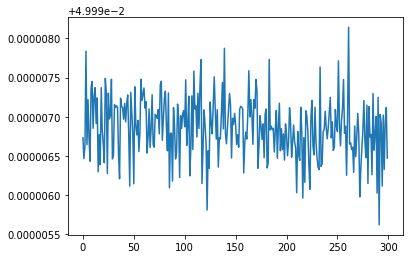

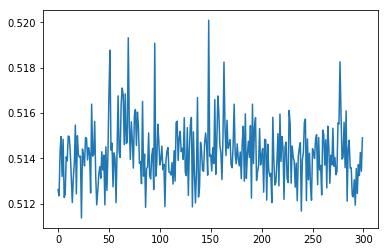

22


100%|██████████| 300/300 [29:17<00:00,  5.85s/it]


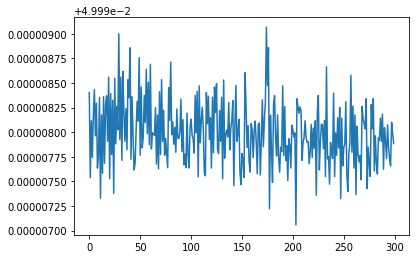

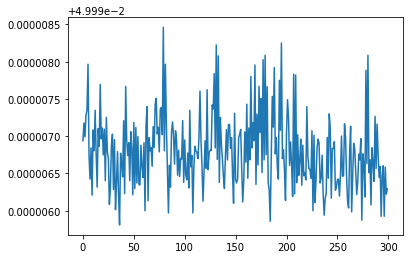

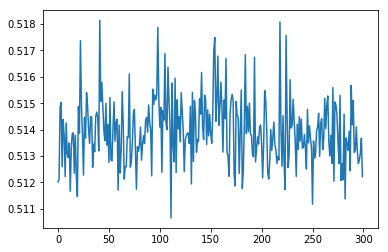

23


100%|██████████| 300/300 [29:20<00:00,  5.85s/it]


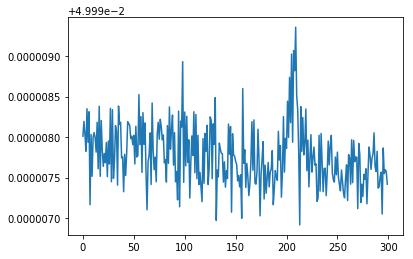

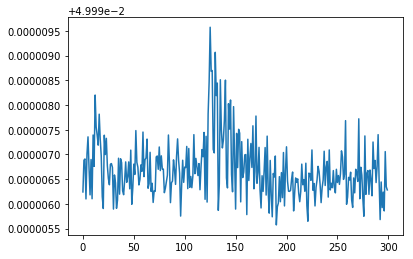

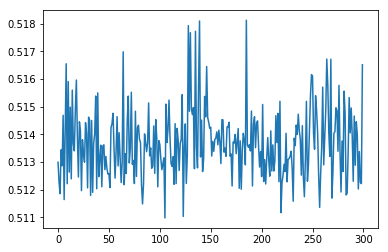

24


 39%|███▉      | 118/300 [11:33<17:47,  5.86s/it]

In [0]:
train(g, f, dx, dy, 0.0001, dl_photo, dl_manga, epochs=50, lmbda=1, e_offset=14)